In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

data_dir = './data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))


train data dim : (15035, 21)
sub data dim : (6468, 21)


In [2]:
# y에 담은 후 라벨을 제거
y = data['price']
del data['price']

train_len = len(data)
data = pd.concat((data, sub), axis=0)

<AxesSubplot:>

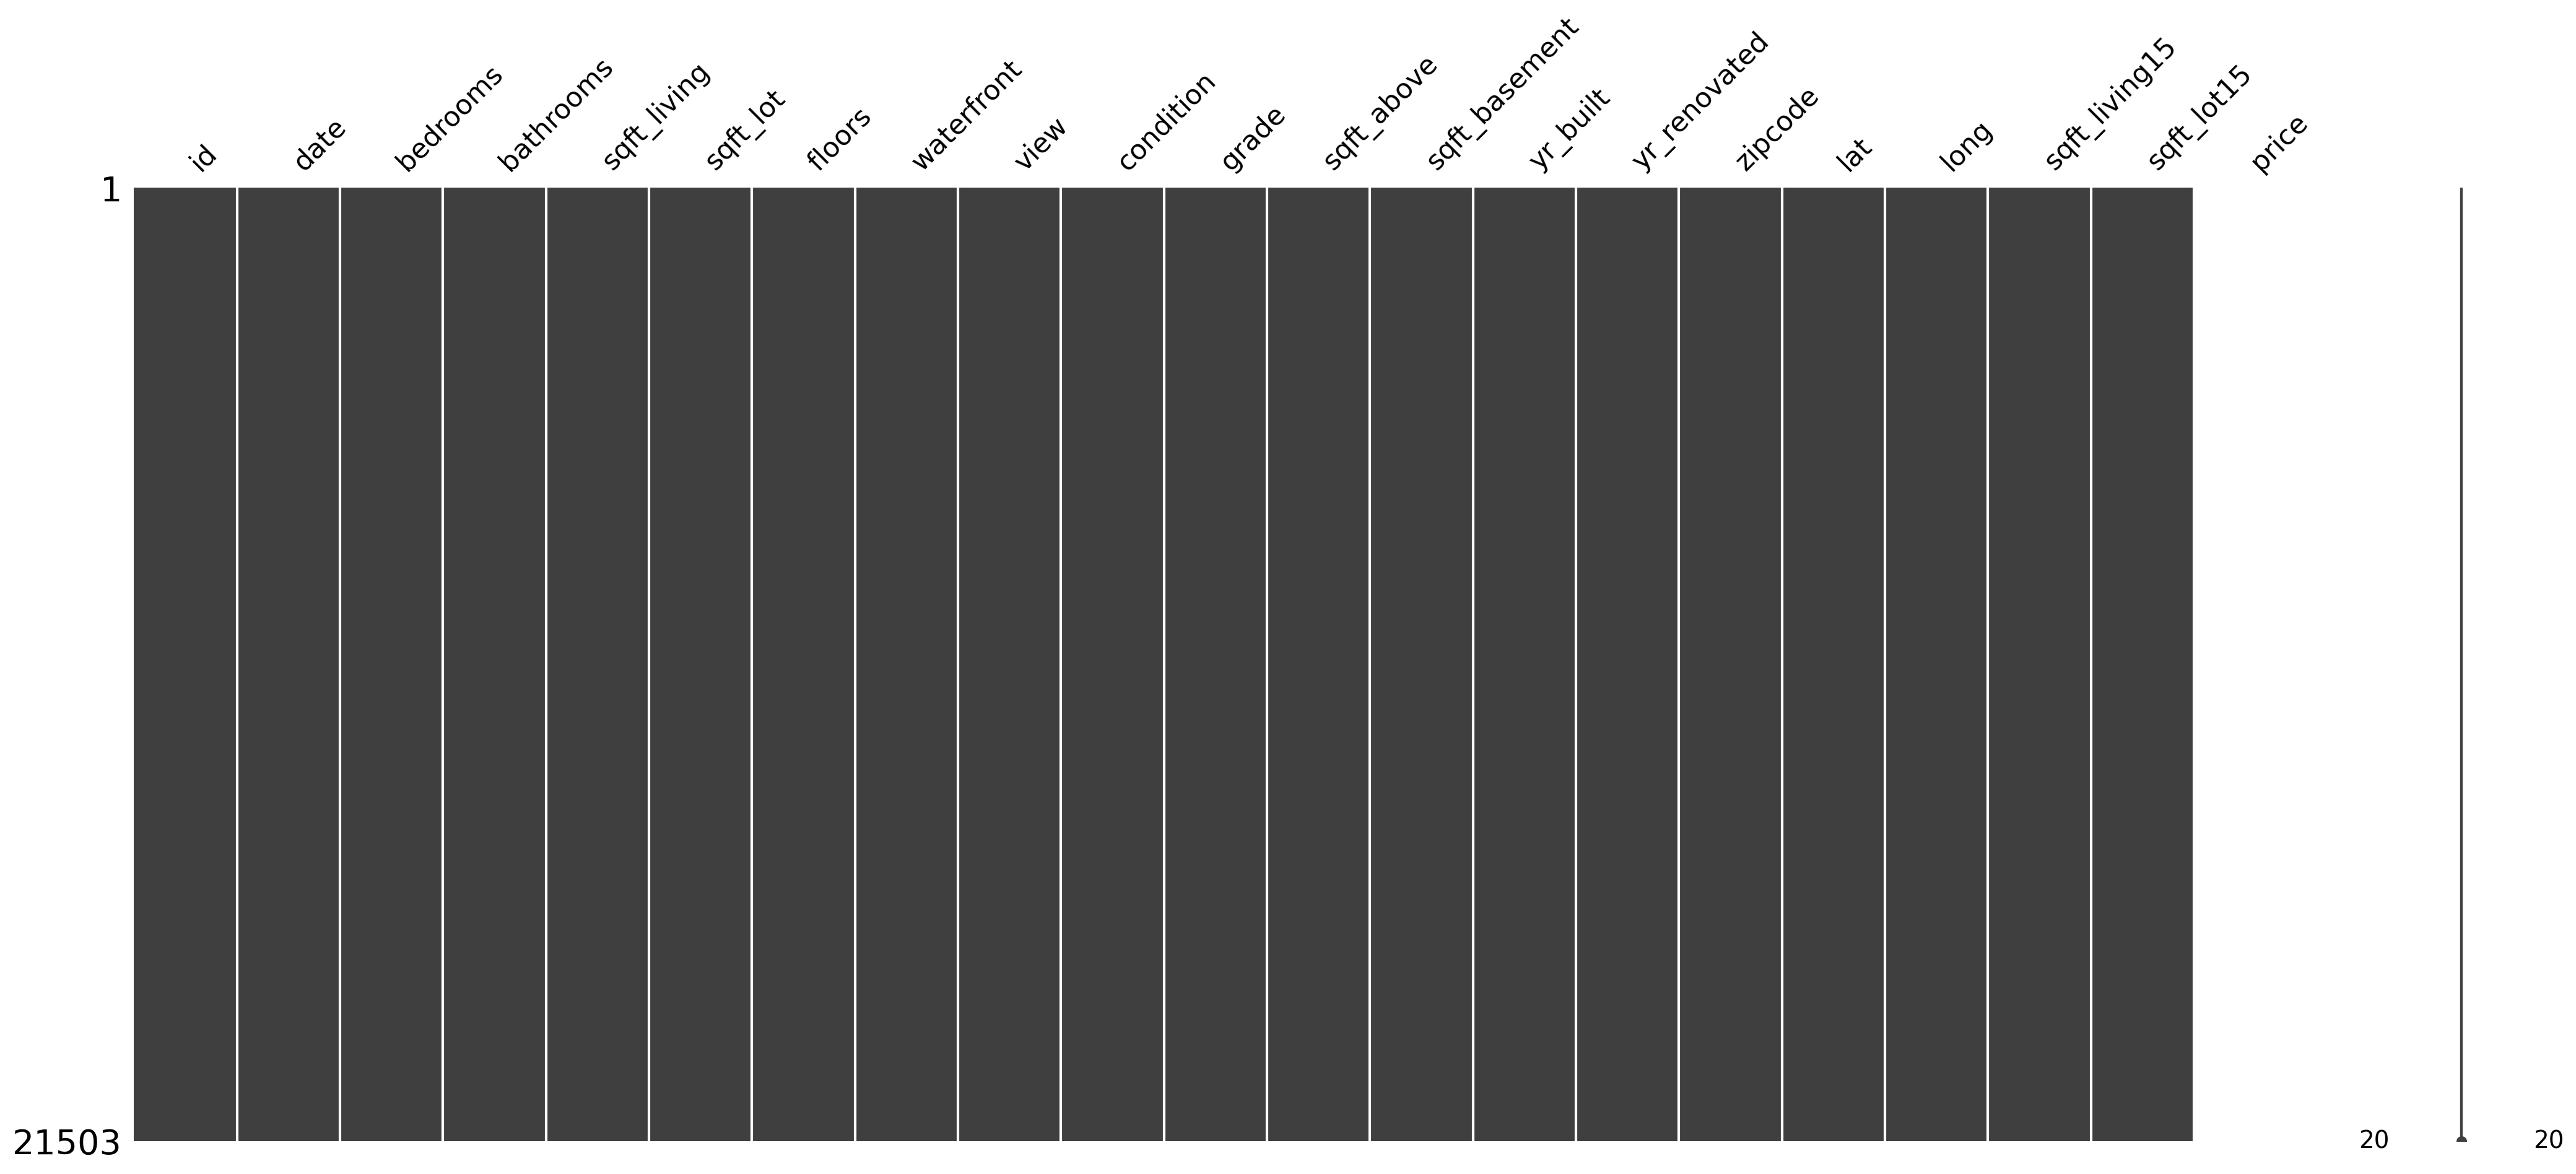

In [3]:
# 결측치 확인 매트릭스 출력
msno.matrix(data)

In [4]:
# 1. id 컬럼이 결측치인지 확인합니다.
null_check = pd.isnull(data['id'])
print(null_check)
# 2. 결측치인 데이터만 뽑아냅니다.
null_data = data.loc[null_check, 'id']
null_data.head()
# 3. 결측치인 데이터의 개수를 셉니다.
print(f'id: {len(null_data.values)}')
# 모든 칼럼에 적용
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

0       False
1       False
2       False
3       False
4       False
        ...  
6463    False
6464    False
6465    False
6466    False
6467    False
Name: id, Length: 21503, dtype: bool
id: 0
id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0
price : 21503


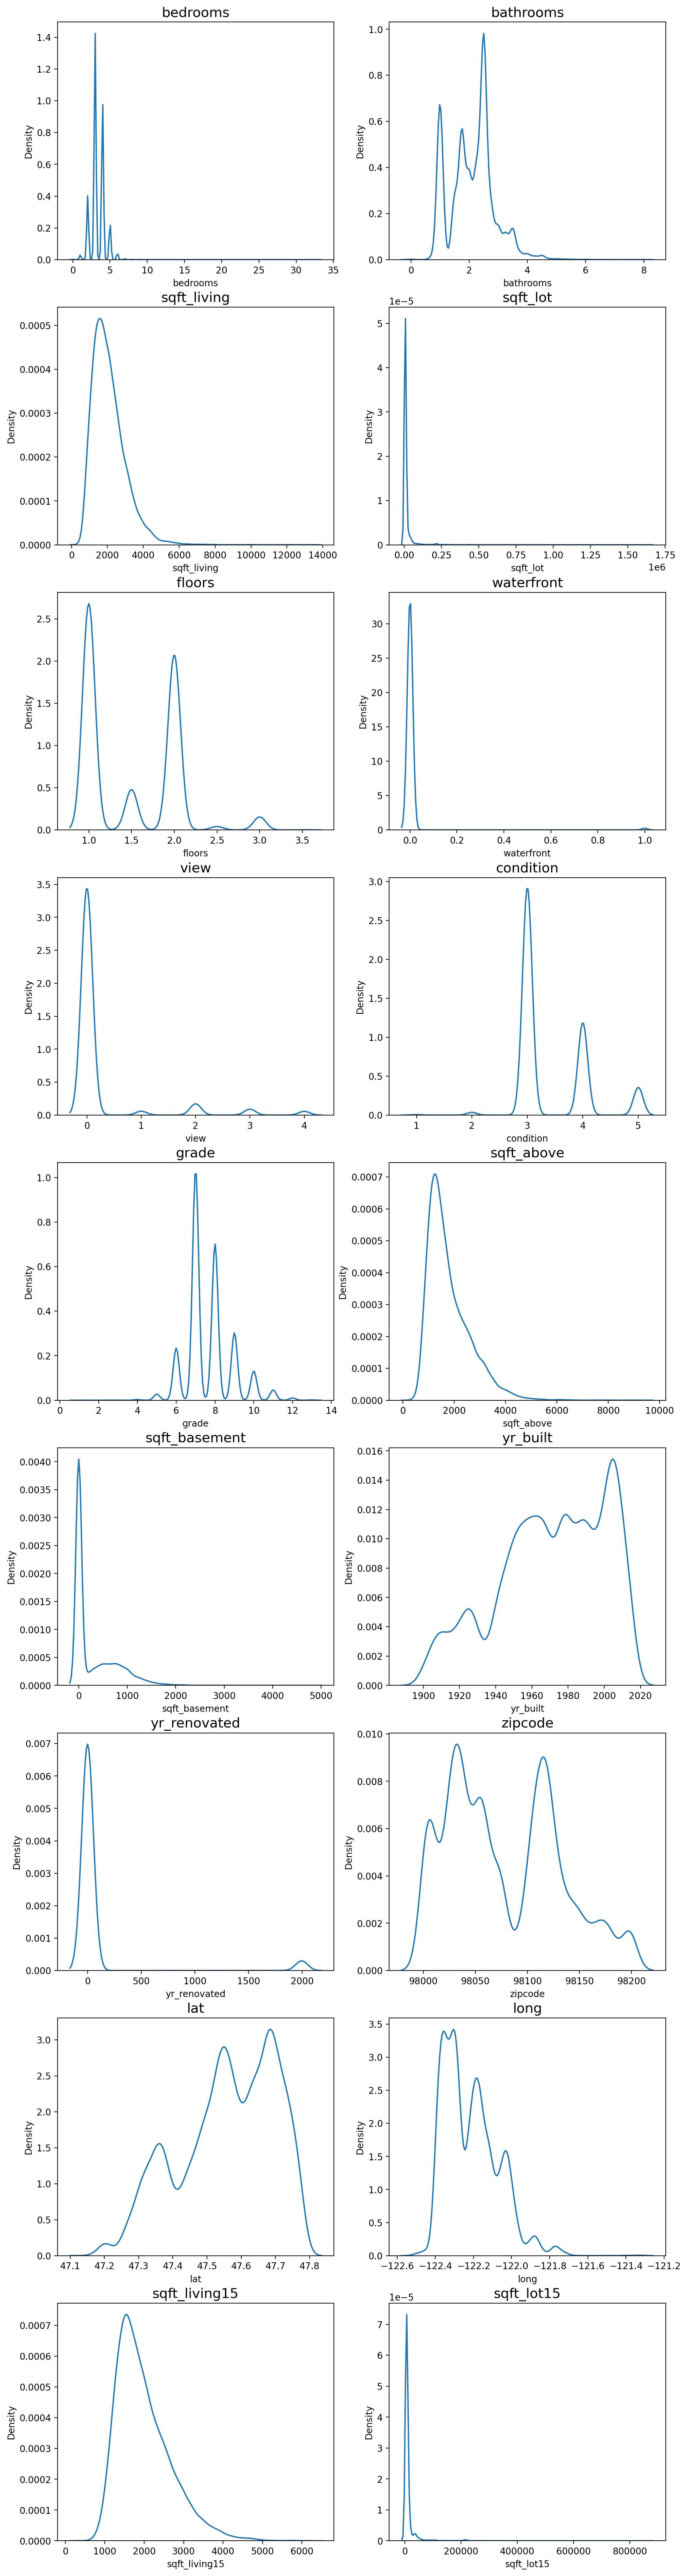

In [5]:
sub_id = data['id'][train_len:]
del data['id']
data['date'] = data['date'].apply(lambda x : str(x[:6]))

# bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement, sqft_living15, sqft_lot15는
# 한쪽으로 치우쳐진 경향이 나타나 log-scaling 필요.
fig, ax = plt.subplots(9, 2, figsize=(12, 50)) 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break
            

In [6]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

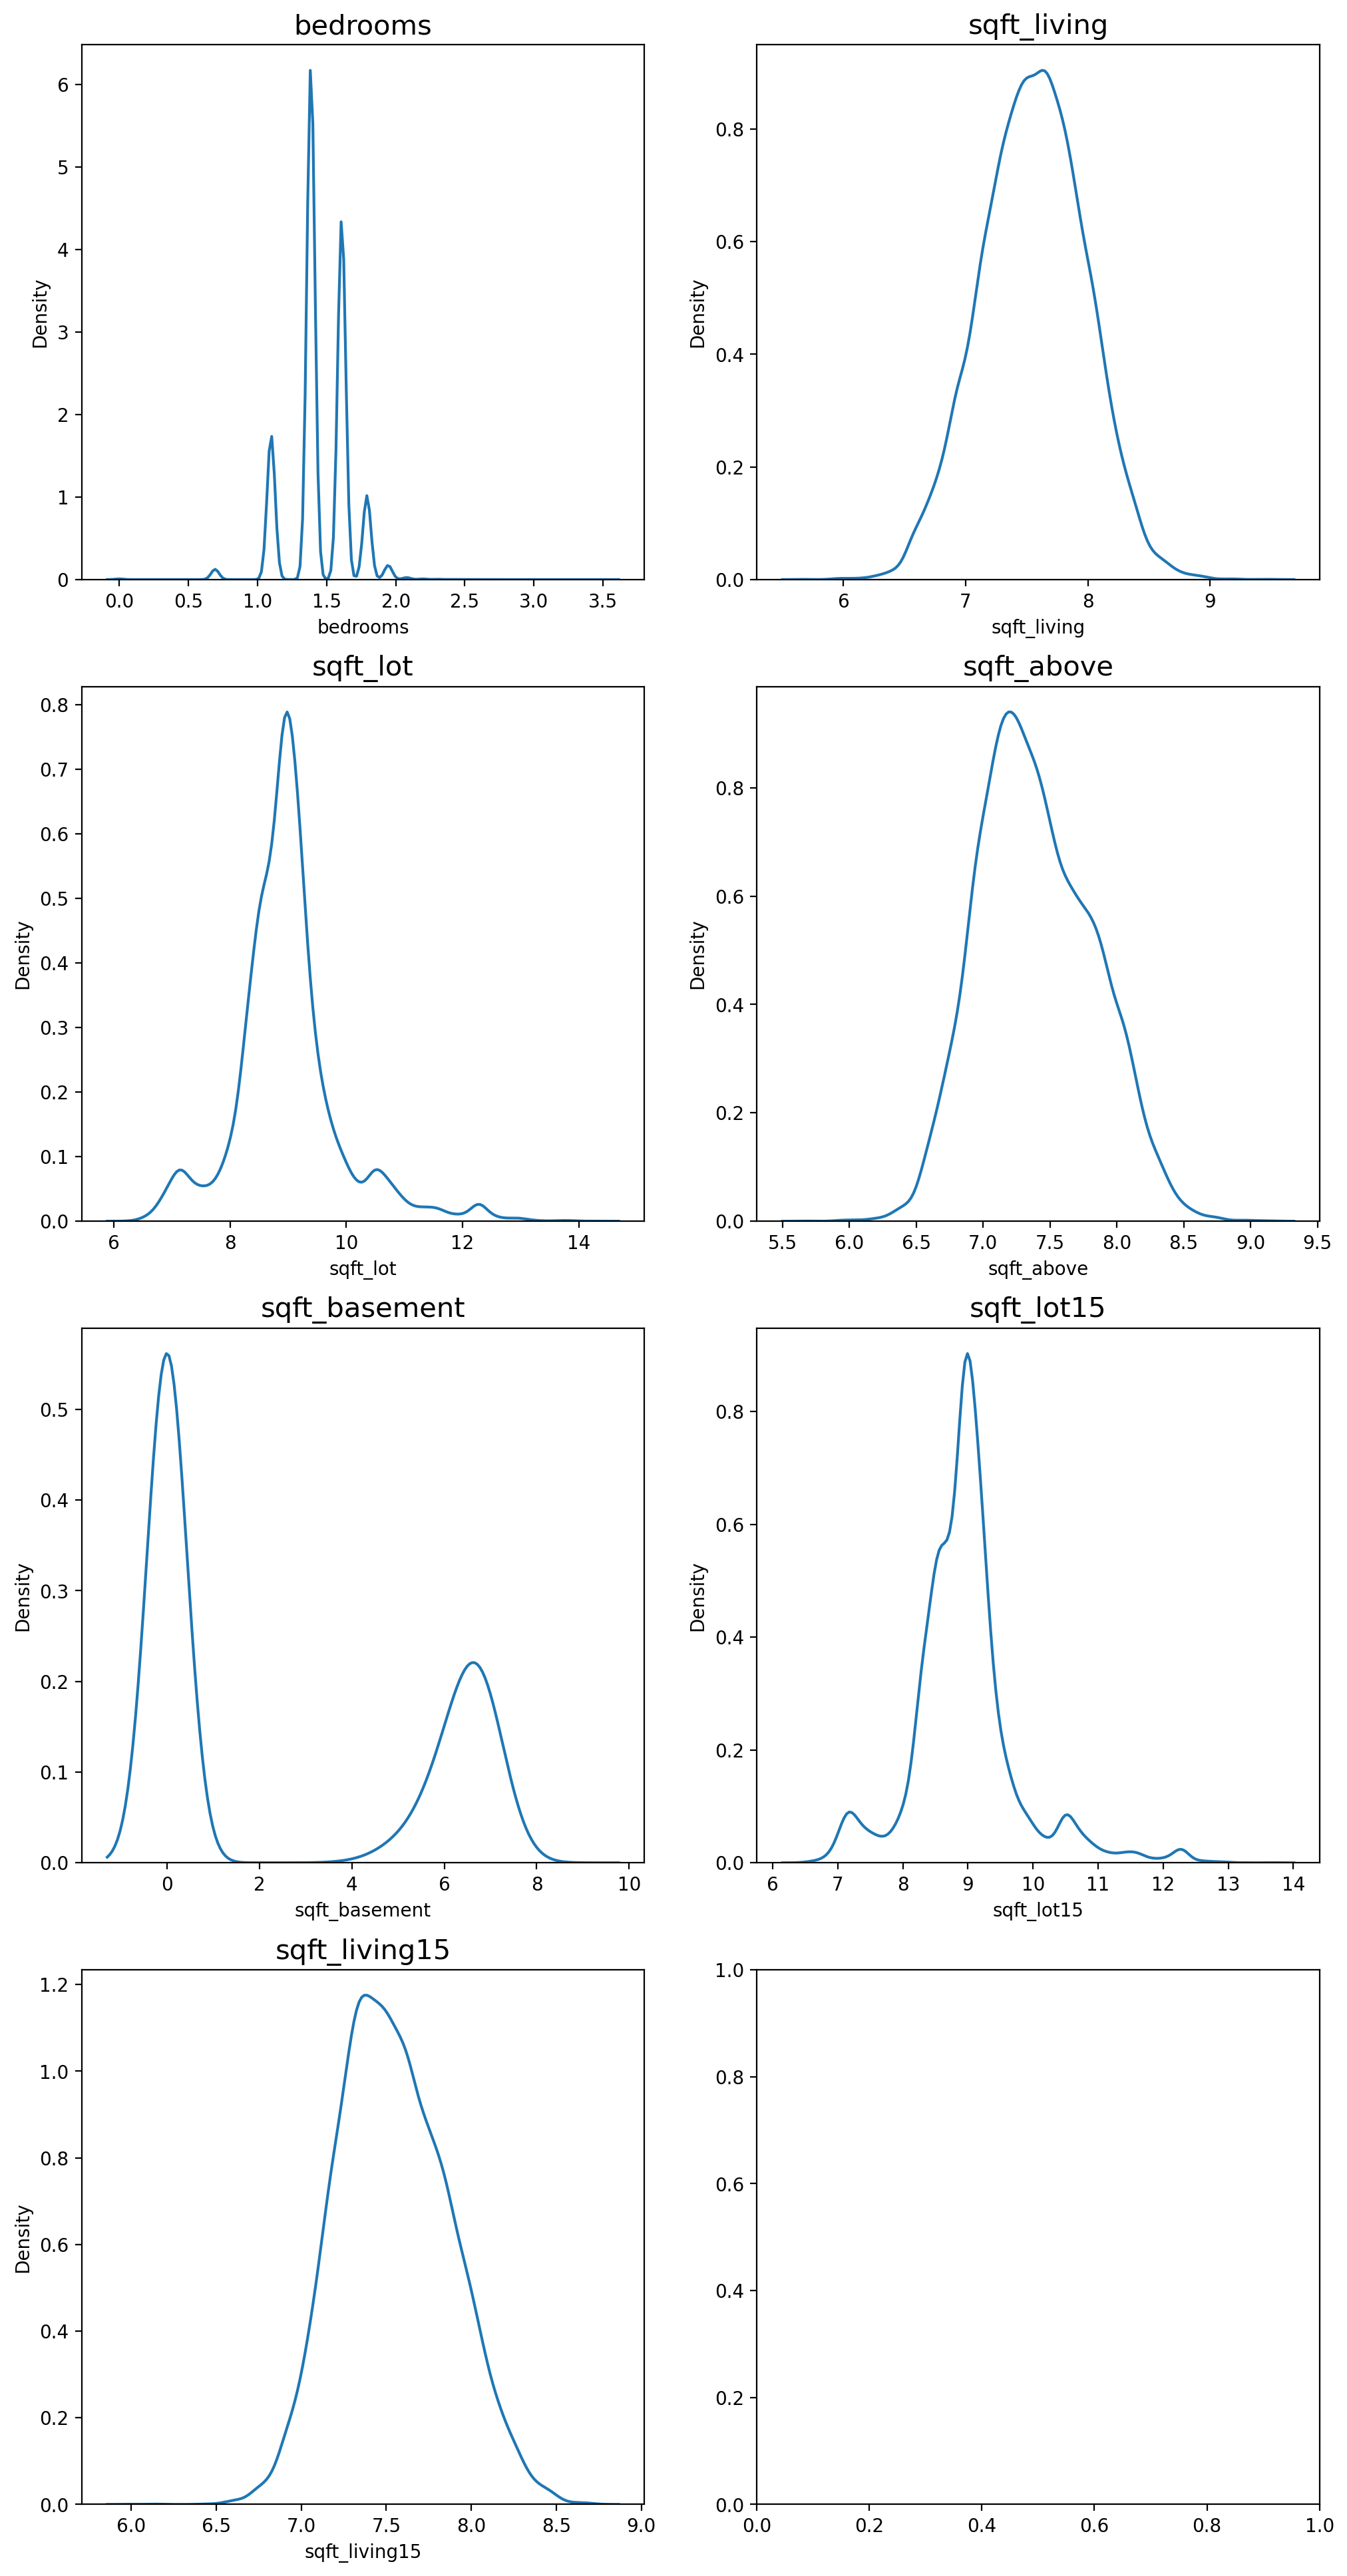

In [7]:
# 치우침이 줄어듦.
fig, ax = plt.subplots(4, 2, figsize=(12, 24))

count = 0
for row in range(4):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(data=data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

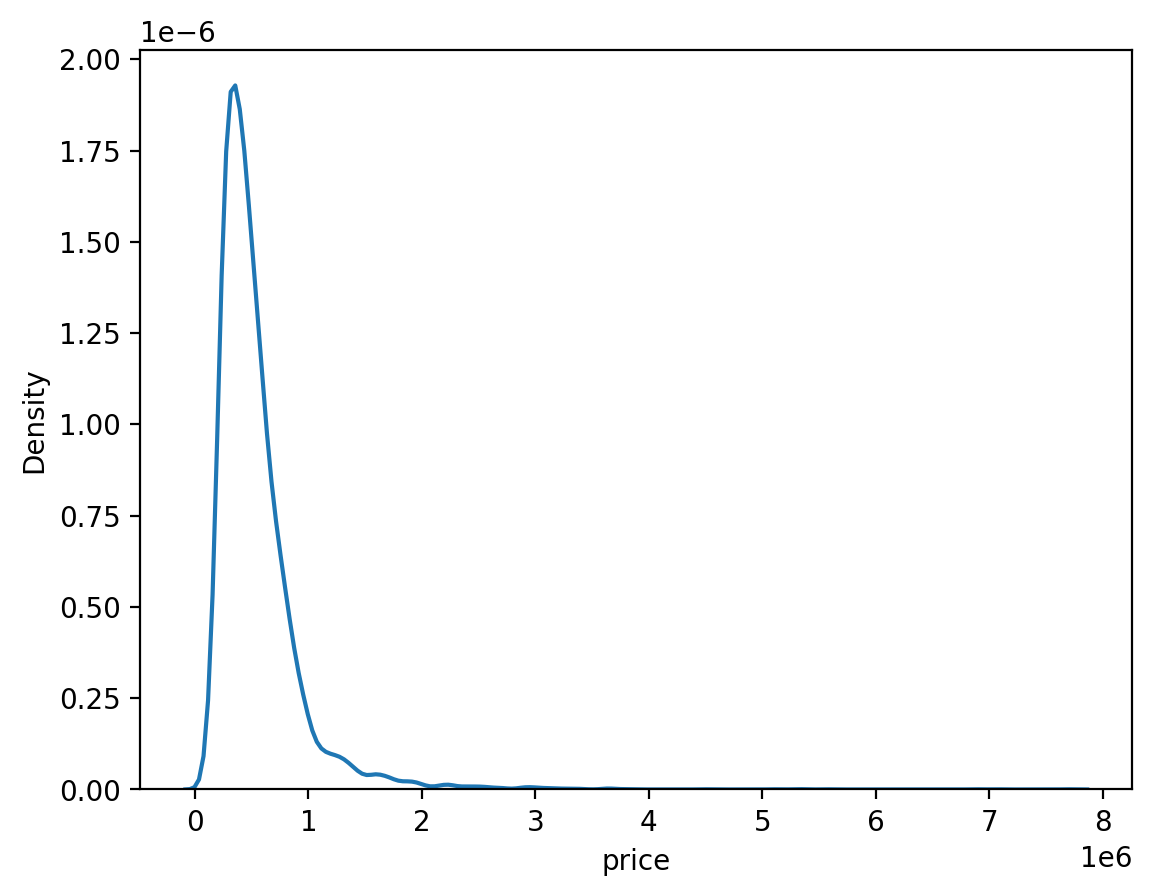

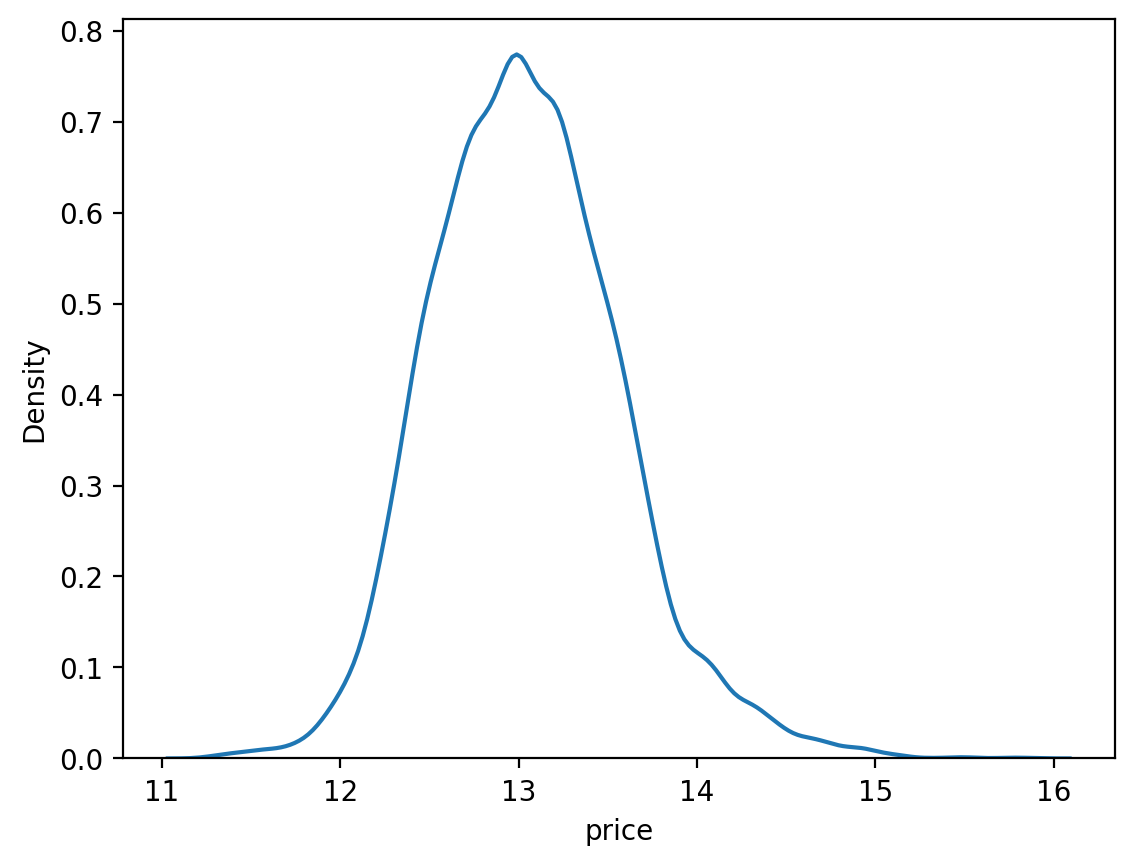

In [8]:
# price(label)도 치우쳐져있는데, log-scaling 해줌.
sns.kdeplot(y)
plt.show()

y_log_transformation = np.log1p(y)

sns.kdeplot(y_log_transformation)
plt.show()

In [9]:
x = data.iloc[:train_len, :]
sub = data.iloc[train_len:, :]

print('x.shape:', x.shape)
print('sub.shape:', sub.shape)

preprocessed_data = pd.concat([x, y], axis=1)
preprocessed_data

x.shape: (15035, 20)
sub.shape: (6468, 20)


,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price,price
0,201410,1.386294,1.00,7.074117,8.639588,1.0,0,0,3,7,...,0.000000,1955,0,98178,47.5112,-122.257,7.201171,8.639588,NaN,221900
1,201502,1.098612,1.00,6.647688,9.210440,1.0,0,0,3,6,...,0.000000,1933,0,98028,47.7379,-122.233,7.908755,8.995041,NaN,180000
2,201502,1.386294,2.00,7.427144,8.997271,1.0,0,0,3,8,...,0.000000,1987,0,98074,47.6168,-122.045,7.496097,8.923191,NaN,510000
3,201406,1.386294,2.25,7.447751,8.827615,2.0,0,0,3,7,...,0.000000,1995,0,98003,47.3097,-122.327,7.713785,8.827615,NaN,257500
4,201501,1.386294,1.50,6.966967,9.181118,1.0,0,0,3,7,...,0.000000,1963,0,98198,47.4095,-122.315,7.409136,9.181118,NaN,291850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,201410,1.609438,2.50,7.832411,8.703507,2.0,0,0,3,9,...,0.000000,2014,0,98056,47.5137,-122.167,7.832411,8.703507,NaN,610685
15031,201503,1.609438,3.50,8.163656,8.881975,2.0,0,0,3,9,...,6.814543,2009,0,98136,47.5537,-122.398,7.626083,8.732466,NaN,1007500
15032,201405,1.386294,2.50,7.333676,7.031741,3.0,0,0,3,8,...,0.000000,2009,0,98103,47.6993,-122.346,7.333676,7.319865,NaN,360000
15033,201502,1.609438,2.50,7.745436,8.668024,2.0,0,0,3,8,...,0.000000,2014,0,98146,47.5107,-122.362,7.512618,8.881975,NaN,400000


---
전처리 끝

In [21]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(x.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=x.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")

get_cv_score(models)

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\JD-Laptop\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JD-Laptop\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_gb.py", line 562, in fit
    X, y = self._validate_data(
  File "C:\Users\JD-Laptop\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py", line 596, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "C:\Users\JD-Laptop\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py", line 1074, in check_X_y
    X = check_array(
  File "C:\Users\JD-Laptop\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py", line 899, in check_array
    _assert_all_finite(
  File "C:\Users\JD-Laptop\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py", line 146, in _assert_all_finite
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
GradientBoostingRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

def get_scores(models, train, y):
    # 답안 작성
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df
# get_scores(models, train, y)


models = []
for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

# TPOT을 이용한 AutoML.

최적 결과 : 


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from tpot import TPOTRegressor

# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# define evaluation procedure
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define search
model = TPOTRegressor(generations=5, population_size=50, scoring='neg_mean_absolute_error', cv=cv, verbosity=2, random_state=1, n_jobs=-1)
# perform the search
model.fit(x, y)
# export the best model
model.export('tpot_insurance_best_model.py')

Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -66584.41031009478

Generation 2 - Current best internal CV score: -66584.41031009478

Generation 3 - Current best internal CV score: -66584.41031009478

Generation 4 - Current best internal CV score: -66552.38077519462

Generation 5 - Current best internal CV score: -66552.38077519462

Best pipeline: GradientBoostingRegressor(input_matrix, alpha=0.9, learning_rate=0.1, loss=huber, max_depth=9, max_features=0.8500000000000001, min_samples_leaf=14, min_samples_split=5, n_estimators=100, subsample=0.25)


In [12]:
from sklearn.pipeline import make_pipeline
from tpot.builtins import StackingEstimator
from sklearn.ensemble import RandomForestRegressor

exported_pipeline = GradientBoostingRegressor(alpha=0.9, learning_rate=0.1, loss="huber", max_depth=9, max_features=0.8500000000000001, 
                                              min_samples_leaf=14, min_samples_split=5, n_estimators=100, subsample=0.25)

exported_pipeline.fit(x, y)

GradientBoostingRegressor(loss='huber', max_depth=9,
                          max_features=0.8500000000000001, min_samples_leaf=14,
                          min_samples_split=5, subsample=0.25)

In [13]:
submission = exported_pipeline.predict(sub)
submission = pd.DataFrame(submission)
submission.to_csv("submit.csv", index = False)
# print(submission)

### 출처 : https://machinelearningmastery.com/tpot-for-automated-machine-learning-in-python/

lazy predict를 이용한 AutoML.

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.2)

In [ ]:
from lazypredict.Supervised import LazyRegressor
clf = LazyRegressor(verbose=0, predictions=True)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)
models

 74%|████████████████████████████████████████████████████████████▌                     | 31/42 [01:25<00:17,  1.60s/it]

## Lazy predict는 74%에서 동작하지 않았다.


## Pycaret을 이용한 AutoML

In [12]:
from pycaret.regression import *
s = setup(data = preprocessed_data, target = 'price', session_id=123)
best = compare_models()
# print(preprocessed_data)

,Description,Value
0,Session id,123
1,Target,price
2,Target type,Regression
3,Data shape,"(15035, 20)"
4,Train data shape,"(10524, 20)"
5,Test data shape,"(4511, 20)"
6,Numeric features,18
7,Categorical features,1
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,70366.7002,17325038877.7105,130477.0677,0.8681,0.1804,0.1367,0.0900
rf,Random Forest Regressor,71966.2637,18882282493.0554,136537.0666,0.8561,0.1805,0.1344,1.5460
gbr,Gradient Boosting Regressor,77774.0099,19414906709.6058,138863.3689,0.8512,0.1916,0.1480,0.5920
xgboost,Extreme Gradient Boosting,77538.4266,19931165184.0000,139687.6586,0.8496,0.2050,0.1605,0.4900
et,Extra Trees Regressor,71475.5849,19765312657.3759,139223.0808,0.8493,0.1782,0.1330,0.9120
dt,Decision Tree Regressor,103186.4433,35618415349.9715,187711.0653,0.7262,0.2555,0.1909,0.0740
ridge,Ridge Regression,128873.8999,44016750464.4114,208587.0253,0.6666,0.4516,0.2691,0.0290
br,Bayesian Ridge,128869.7280,44019044825.2428,208592.0991,0.6665,0.4495,0.2691,0.0310
llar,Lasso Least Angle Regression,128821.6439,44020786087.5441,208595.1257,0.6665,0.4508,0.2690,0.0290
lasso,Lasso Regression,128926.9574,44018889440.5960,208596.1605,0.6665,0.4489,0.2693,0.0750


In [13]:
# lightGBM모델이 선택되었다.
lightgbm = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,68163.1879,12114606951.0505,110066.3752,0.9221,0.1713,0.1342
1,67762.6580,15831647481.5097,125823.8748,0.8735,0.1701,0.1301
2,72545.5020,15141248605.4857,123049.7810,0.8842,0.1842,0.1403
3,69729.7781,14128661727.3715,118864.0472,0.8789,0.1838,0.1382
4,70557.6876,30068110640.2396,173401.5878,0.8332,0.1838,0.1378
5,68621.0956,15748333789.0512,125492.3655,0.8693,0.1788,0.1337
6,66522.3607,21959329521.5141,148186.8062,0.8224,0.1704,0.1284
7,76986.2407,17770175628.5367,133304.8222,0.8589,0.2010,0.1493
8,74785.5709,16872088821.0407,129892.6050,0.8537,0.1845,0.1403


In [14]:
# LightGBM Tuning
lgbm_params = {'num_leaves': np.arange(10,200,10),
                        'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
                        'learning_rate': np.arange(0.1,1,0.1)
                        }
tuned_lightgbm = tune_model(lightgbm, custom_grid = lgbm_params)
print(tuned_lightgbm)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,73501.4220,13433127108.3226,115901.3680,0.9136,0.1922,0.1535
1,72456.8873,17857495206.6306,133631.9393,0.8573,0.1876,0.1465
2,73630.5670,15528799168.5734,124614.6025,0.8813,0.1908,0.1474
3,75567.4783,15584013761.1418,124835.9474,0.8664,0.2016,0.1574
4,73499.4482,29820376565.6326,172685.7741,0.8346,0.1967,0.1509
5,73953.8823,18317951370.6378,135343.8265,0.8480,0.1945,0.1487
6,70901.5163,23345111631.6810,152791.0718,0.8112,0.1833,0.1438
7,79123.6503,18059531618.2037,134385.7568,0.8566,0.2122,0.1615
8,79903.3271,18608688312.4210,136413.6661,0.8386,0.2022,0.1592


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
LGBMRegressor(random_state=123)


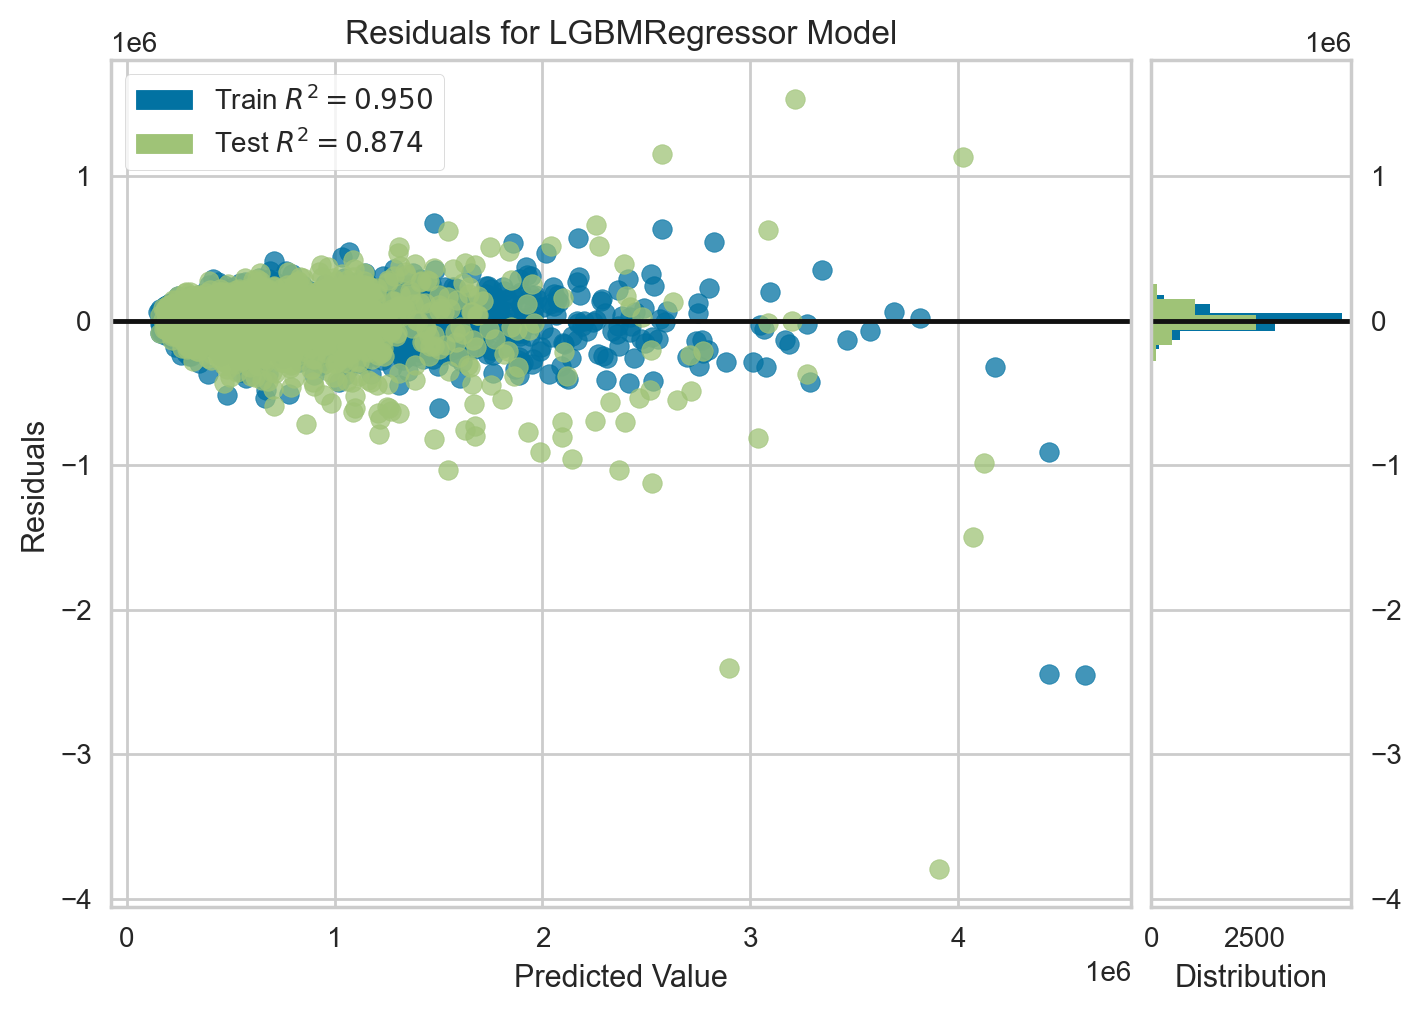

In [15]:
#Residual Plot
plot_model(tuned_lightgbm)

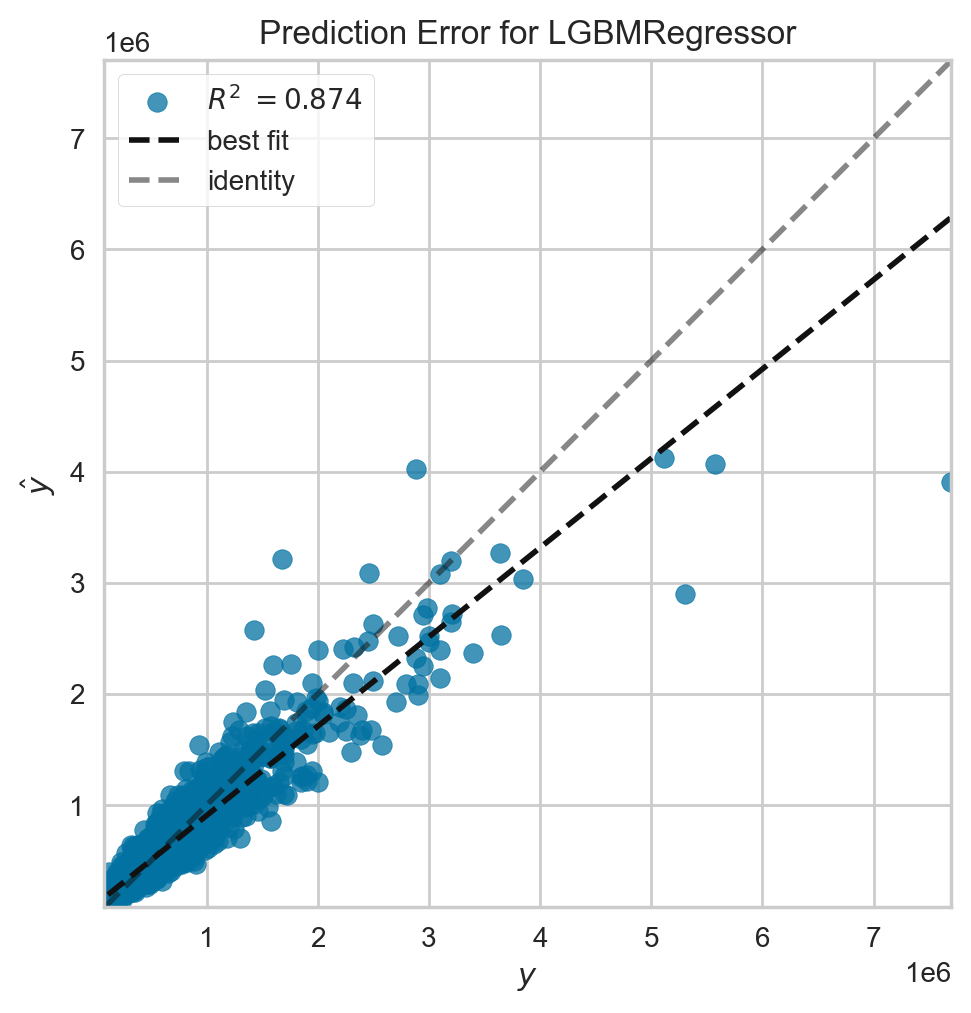

In [16]:
# Prediction Error Plot
plot_model(tuned_lightgbm, plot = 'error')

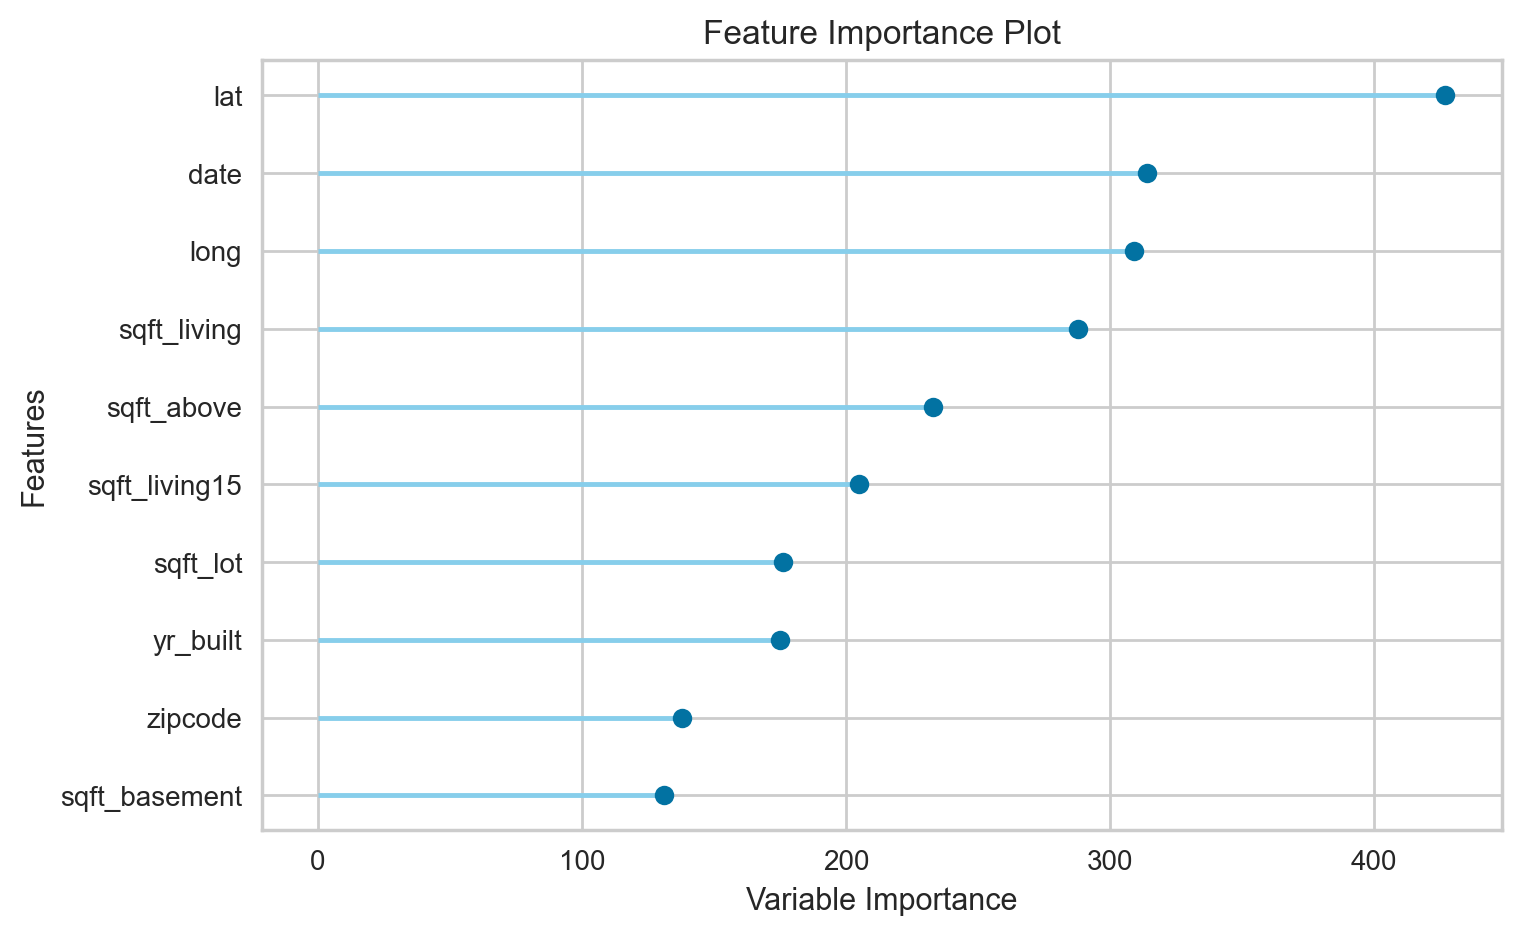

In [17]:
# Feature Importance Plot
plot_model(tuned_lightgbm, plot='feature')

In [18]:
# UI가 편리한 여러가지 그래프를 나타내준다.
evaluate_model(tuned_lightgbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [19]:
# Finalization
final_lightgbm = finalize_model(tuned_lightgbm)
print(final_lightgbm)

Pipeline(memory=Memory(location=C:\Users\JD-Laptop\AppData\Local\Temp\joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['bedrooms', 'bathrooms',
                                             'sqft_living', 'sqft_lot',
                                             'floors', 'waterfront', 'view',
                                             'condition', 'grade', 'sqft_above',
                                             'sqft_basement', 'yr_built',
                                             'yr_renovated', 'zipcode', 'lat',
                                             'long', 'sqft_living15',
                                             'sqft_lot15'],
                                    transformer...
                                    transformer=SimpleImputer(fill_value='constant',
                                                              strategy='constant'))),
                ('rest_encoding',
                 TransformerWrapper(include=

In [20]:
# finalized된 모델과 튜닝된 모델, 꽤 성능이 차이난다.
predict_model(tuned_lightgbm)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,71346.5750,19375637585.9099,139196.3993,0.8740,0.1792,0.1360


,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price,prediction_label
10524,530593.602972,1.609438,2.50,7.749753,9.329012,2.0,0.0,0.0,3.0,9.0,...,0.000000,1982.0,0.0,98004.0,47.644299,-122.194000,7.944847,9.373394,640000.0,940294.151971
10525,548126.989632,1.609438,2.50,8.108021,9.384461,2.0,0.0,0.0,5.0,9.0,...,6.508769,1977.0,0.0,98006.0,47.554001,-122.160004,7.901377,9.316051,852600.0,969604.650707
10526,537262.420354,1.609438,2.75,8.172165,9.511629,2.0,0.0,0.0,3.0,10.0,...,0.000000,1998.0,0.0,98075.0,47.594501,-121.982002,8.172165,9.353488,820000.0,792637.283526
10527,541424.644991,1.609438,2.25,7.852050,9.159468,2.0,0.0,0.0,3.0,8.0,...,0.000000,1980.0,0.0,98011.0,47.764000,-122.167000,7.576097,9.169622,439000.0,491251.281550
10528,526616.861622,1.609438,2.50,7.871311,9.212039,2.0,0.0,0.0,3.0,8.0,...,0.000000,1996.0,0.0,98056.0,47.529499,-122.179001,7.871311,9.212039,565000.0,550439.349055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,526616.861622,1.386294,1.75,7.824446,9.022805,1.0,0.0,0.0,4.0,7.0,...,7.131699,1958.0,0.0,98056.0,47.497299,-122.177002,7.444833,9.012621,315000.0,342486.663886
15031,517289.028630,1.609438,2.75,7.555382,8.883363,1.0,0.0,0.0,4.0,7.0,...,6.175867,1980.0,0.0,98030.0,47.369301,-122.168999,7.467942,8.915566,200000.0,274267.649708
15032,526616.861622,1.609438,3.50,7.775276,8.667336,2.0,0.0,0.0,4.0,7.0,...,6.447306,1995.0,0.0,98106.0,47.553600,-122.359001,7.390799,8.661467,413000.0,473622.415546
15033,537262.420354,1.098612,1.00,6.685861,9.053803,1.0,0.0,0.0,3.0,7.0,...,0.000000,1947.0,0.0,98198.0,47.407501,-122.293999,7.307202,9.053803,95000.0,201512.151310


In [21]:
predict_model(final_lightgbm)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,82825.3508,13709983857.0250,117089.6403,0.9108,0.2185,0.1875


,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price,prediction_label
10524,530593.602972,1.609438,2.50,7.749753,9.329012,2.0,0.0,0.0,3.0,9.0,...,0.000000,1982.0,0.0,98004.0,47.644299,-122.194000,7.944847,9.373394,640000.0,844394.533179
10525,548126.989632,1.609438,2.50,8.108021,9.384461,2.0,0.0,0.0,5.0,9.0,...,6.508769,1977.0,0.0,98006.0,47.554001,-122.160004,7.901377,9.316051,852600.0,950239.805985
10526,537262.420354,1.609438,2.75,8.172165,9.511629,2.0,0.0,0.0,3.0,10.0,...,0.000000,1998.0,0.0,98075.0,47.594501,-121.982002,8.172165,9.353488,820000.0,847572.736766
10527,541424.644991,1.609438,2.25,7.852050,9.159468,2.0,0.0,0.0,3.0,8.0,...,0.000000,1980.0,0.0,98011.0,47.764000,-122.167000,7.576097,9.169622,439000.0,577240.563140
10528,526616.861622,1.609438,2.50,7.871311,9.212039,2.0,0.0,0.0,3.0,8.0,...,0.000000,1996.0,0.0,98056.0,47.529499,-122.179001,7.871311,9.212039,565000.0,541354.104402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,526616.861622,1.386294,1.75,7.824446,9.022805,1.0,0.0,0.0,4.0,7.0,...,7.131699,1958.0,0.0,98056.0,47.497299,-122.177002,7.444833,9.012621,315000.0,337503.114130
15031,517289.028630,1.609438,2.75,7.555382,8.883363,1.0,0.0,0.0,4.0,7.0,...,6.175867,1980.0,0.0,98030.0,47.369301,-122.168999,7.467942,8.915566,200000.0,267830.908626
15032,526616.861622,1.609438,3.50,7.775276,8.667336,2.0,0.0,0.0,4.0,7.0,...,6.447306,1995.0,0.0,98106.0,47.553600,-122.359001,7.390799,8.661467,413000.0,452464.501617
15033,537262.420354,1.098612,1.00,6.685861,9.053803,1.0,0.0,0.0,3.0,7.0,...,0.000000,1947.0,0.0,98198.0,47.407501,-122.293999,7.307202,9.053803,95000.0,272192.589382


In [25]:
submission = predict_model(final_lightgbm, data=sub)
submission.to_csv("submit pycaret.csv", index = False)

PermissionError: [Errno 13] Permission denied: 'submit pycaret.csv'

출처 : https://towardsdatascience.com/introduction-to-regression-in-python-with-pycaret-d6150b540fc4

# FLAML을 이용한 AutoML

In [10]:
!pip install flaml

Defaulting to user installation because normal site-packages is not writeable


In [15]:
from flaml import AutoML
automl = AutoML()
automl.fit(x, y, task="regression", time_budget=2000)
print(automl.model)
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))


[flaml.automl: 11-14 03:00:40] {2600} INFO - task = regression
[flaml.automl: 11-14 03:00:40] {2602} INFO - Data split method: uniform
[flaml.automl: 11-14 03:00:40] {2605} INFO - Evaluation method: cv
[flaml.automl: 11-14 03:00:40] {2727} INFO - Minimizing error metric: 1-r2
[flaml.automl: 11-14 03:00:40] {2869} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth']
[flaml.automl: 11-14 03:00:40] {3164} INFO - iteration 0, current learner lgbm
[flaml.automl: 11-14 03:00:40] {3297} INFO - Estimated sufficient time budget=2723s. Estimated necessary time budget=19s.
[flaml.automl: 11-14 03:00:40] {3344} INFO -  at 0.4s,	estimator lgbm's best error=0.7097,	best estimator lgbm's best error=0.7097
[flaml.automl: 11-14 03:00:40] {3164} INFO - iteration 1, current learner lgbm
[flaml.automl: 11-14 03:00:40] {3344} INFO -  at 0.6s,	estimator lgbm's best error=0.7097,	best estimator lgbm's best error=0.7097
[flaml.automl: 11-14 03:00:40] {3164} INFO 

[flaml.automl: 11-14 03:01:02] {3164} INFO - iteration 36, current learner extra_tree
[flaml.automl: 11-14 03:01:03] {3344} INFO -  at 22.8s,	estimator extra_tree's best error=0.1535,	best estimator lgbm's best error=0.1095
[flaml.automl: 11-14 03:01:03] {3164} INFO - iteration 37, current learner rf
[flaml.automl: 11-14 03:01:03] {3344} INFO -  at 23.4s,	estimator rf's best error=0.1548,	best estimator lgbm's best error=0.1095
[flaml.automl: 11-14 03:01:03] {3164} INFO - iteration 38, current learner xgboost
[flaml.automl: 11-14 03:01:04] {3344} INFO -  at 23.9s,	estimator xgboost's best error=0.2576,	best estimator lgbm's best error=0.1095
[flaml.automl: 11-14 03:01:04] {3164} INFO - iteration 39, current learner xgboost
[flaml.automl: 11-14 03:01:04] {3344} INFO -  at 24.4s,	estimator xgboost's best error=0.2198,	best estimator lgbm's best error=0.1095
[flaml.automl: 11-14 03:01:04] {3164} INFO - iteration 40, current learner xgboost
[flaml.automl: 11-14 03:01:05] {3344} INFO -  at 

[flaml.automl: 11-14 03:02:39] {3164} INFO - iteration 74, current learner xgboost
[flaml.automl: 11-14 03:02:41] {3344} INFO -  at 121.0s,	estimator xgboost's best error=0.1112,	best estimator lgbm's best error=0.0957
[flaml.automl: 11-14 03:02:41] {3164} INFO - iteration 75, current learner extra_tree
[flaml.automl: 11-14 03:02:42] {3344} INFO -  at 122.3s,	estimator extra_tree's best error=0.1410,	best estimator lgbm's best error=0.0957
[flaml.automl: 11-14 03:02:42] {3164} INFO - iteration 76, current learner rf
[flaml.automl: 11-14 03:02:46] {3344} INFO -  at 126.1s,	estimator rf's best error=0.1275,	best estimator lgbm's best error=0.0957
[flaml.automl: 11-14 03:02:46] {3164} INFO - iteration 77, current learner rf
[flaml.automl: 11-14 03:02:48] {3344} INFO -  at 128.3s,	estimator rf's best error=0.1275,	best estimator lgbm's best error=0.0957
[flaml.automl: 11-14 03:02:48] {3164} INFO - iteration 78, current learner xgboost
[flaml.automl: 11-14 03:02:49] {3344} INFO -  at 129.1s

[flaml.automl: 11-14 03:08:07] {3344} INFO -  at 447.3s,	estimator lgbm's best error=0.0955,	best estimator lgbm's best error=0.0955
[flaml.automl: 11-14 03:08:07] {3164} INFO - iteration 112, current learner xgb_limitdepth
[flaml.automl: 11-14 03:08:11] {3344} INFO -  at 451.2s,	estimator xgb_limitdepth's best error=0.1193,	best estimator lgbm's best error=0.0955
[flaml.automl: 11-14 03:08:11] {3164} INFO - iteration 113, current learner xgb_limitdepth
[flaml.automl: 11-14 03:08:13] {3344} INFO -  at 453.6s,	estimator xgb_limitdepth's best error=0.1193,	best estimator lgbm's best error=0.0955
[flaml.automl: 11-14 03:08:13] {3164} INFO - iteration 114, current learner xgb_limitdepth
[flaml.automl: 11-14 03:08:21] {3344} INFO -  at 461.3s,	estimator xgb_limitdepth's best error=0.1063,	best estimator lgbm's best error=0.0955
[flaml.automl: 11-14 03:08:21] {3164} INFO - iteration 115, current learner xgb_limitdepth
[flaml.automl: 11-14 03:08:24] {3344} INFO -  at 464.6s,	estimator xgb_lim

[flaml.automl: 11-14 03:21:47] {3344} INFO -  at 1267.6s,	estimator lgbm's best error=0.0955,	best estimator lgbm's best error=0.0955
[flaml.automl: 11-14 03:21:47] {3164} INFO - iteration 149, current learner lgbm
[flaml.automl: 11-14 03:21:50] {3344} INFO -  at 1269.9s,	estimator lgbm's best error=0.0955,	best estimator lgbm's best error=0.0955
[flaml.automl: 11-14 03:21:50] {3164} INFO - iteration 150, current learner lgbm
[flaml.automl: 11-14 03:23:28] {3344} INFO -  at 1368.6s,	estimator lgbm's best error=0.0951,	best estimator lgbm's best error=0.0951
[flaml.automl: 11-14 03:23:28] {3164} INFO - iteration 151, current learner lgbm
[flaml.automl: 11-14 03:23:38] {3344} INFO -  at 1377.9s,	estimator lgbm's best error=0.0951,	best estimator lgbm's best error=0.0951
[flaml.automl: 11-14 03:23:38] {3164} INFO - iteration 152, current learner extra_tree
[flaml.automl: 11-14 03:23:42] {3344} INFO -  at 1382.4s,	estimator extra_tree's best error=0.1240,	best estimator lgbm's best error=0

Best ML leaner: lgbm
Best hyperparmeter config: {'n_estimators': 4028, 'num_leaves': 40, 'min_child_samples': 2, 'learning_rate': 0.041407949886253424, 'log_max_bin': 10, 'colsample_bytree': 0.7041640489579002, 'reg_alpha': 0.01822387703098054, 'reg_lambda': 0.007928422613423212}
Best accuracy on validation data: 0.9049
Training duration of best run: 20.06 s


In [36]:
# del x['price']
# del x['date']
# print(sub)
del sub['date']
del sub['price']

In [40]:
from lightgbm import LGBMRegressor
model = LGBMRegressor(n_estimators=4028, num_leaves= 40, min_child_samples= 2, learning_rate=0.041407949886253424, colsample_bytree= 0.7041640489579002, reg_alpha= 0.01822387703098054, reg_lambda= 0.007928422613423212)
model.fit(x, y)

prediction = model.predict(sub)
# prediction = np.expm1(prediction)
# prediction = np.expm1(prediction)

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission['price'] = prediction
submission_csv_path = '{}/submission.csv'.format(data_dir)
submission.to_csv(submission_csv_path, index=False)

# auto-Alex를 이용한 AutoML

In [41]:
!pip install automl-alex

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 52.4/52.4 kB ? eta 0:00:00
  Using cached catboost-1.1.1-cp39-none-win_amd64.whl (74.0 MB)
     ---------------------------------------- 2.5/2.5 MB 11.5 MB/s eta 0:00:00
     ---------------------------------------- 58.3/58.3 kB 3.0 MB/s eta 0:00:00
  Using cached optuna-3.0.3-py3-none-any.whl (348 kB)
  Using cached graphviz-0.20.1-py3-none-any.whl (47 kB)
  Using cached cliff-4.0.0-py3-none-any.whl (80 kB)
  Using cached colorlog-6.7.0-py2.py3-none-any.whl (11 kB)
  Using cached scipy-1.8.1-cp39-cp39-win_amd64.whl (36.9 MB)
  Using cached alembic-1.8.1-py3-none-any.whl (209 kB)
     ---------------------------------------- 90.1/90.1 kB ? eta 0:00:00
  Using cached Mako-1.2.3-py3-none-any.whl (78 kB)
  Using cached cmd2-2.4.2-py3-none-any.whl (147 kB)
     ---------------------------------------- 50.0/50.0 kB ? eta 0:00:00
  Using cached prettytable-3.5.0-py3-non

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pycaret 3.0.0rc4 requires importlib-metadata>=4.12.0, but you have importlib-metadata 4.11.3 which is incompatible.


In [42]:
from automl_alex import AutoMLRegressor

In [43]:
model = AutoMLRegressor()
model.fit(x, y, timeout=600)
predicts = model.predict(sub)

03:52:00 | > Start Fit Base Model
03:52:07 | ##################################################
03:52:07 | > Start Fit Models 2
03:52:07 | ##################################################
03:52:07 | ##################################################
03:52:08 | > Step 1: calc parameters and pruned score: get test 10 trials


04:01:04 |  One iteration ~ 53.6 sec
04:01:04 |  Possible iters ~ 8.0
04:01:04 | ! Not enough time to find the optimal parameters. 
                     Possible iters < 100. 
                     Please, Increase the 'timeout' parameter for normal optimization.
04:01:04 | --------------------------------------------------
04:01:04 |   Pruned Threshold Score: 20981139854.0852
04:01:04 | ##################################################
04:01:04 | > Step 2: Full opt with Threshold Score Pruner
04:01:04 | ##################################################
04:01:04 | > Start optimization with the parameters:
04:01:04 | CV_Folds = 7
04:01:04 | Score_CV_Folds = 3
04:01:04 | Feature_Selection = False
04:01:04 | Opt_lvl = 1
04:01:04 | Cold_start = 15
04:01:04 | Early_stoping = 25
04:01:04 | Metric = mean_squared_error
04:01:04 | Direction = minimize
04:01:04 | ##################################################
Optimize: : 0it [00:00, ?it/s]
04:01:04 | > Finish Opt!
04:01:04 | Best Score: 169

In [46]:
submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission['price'] = predicts
submission_csv_path = '{}/submission.csv'.format(data_dir)
submission.to_csv(submission_csv_path, index=False)

# AutoML 사용하지않음

In [8]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.model_selection import KFold, cross_val_score

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor



data_dir = './data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
y = train['price']
del train['price']
del train['id']
print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


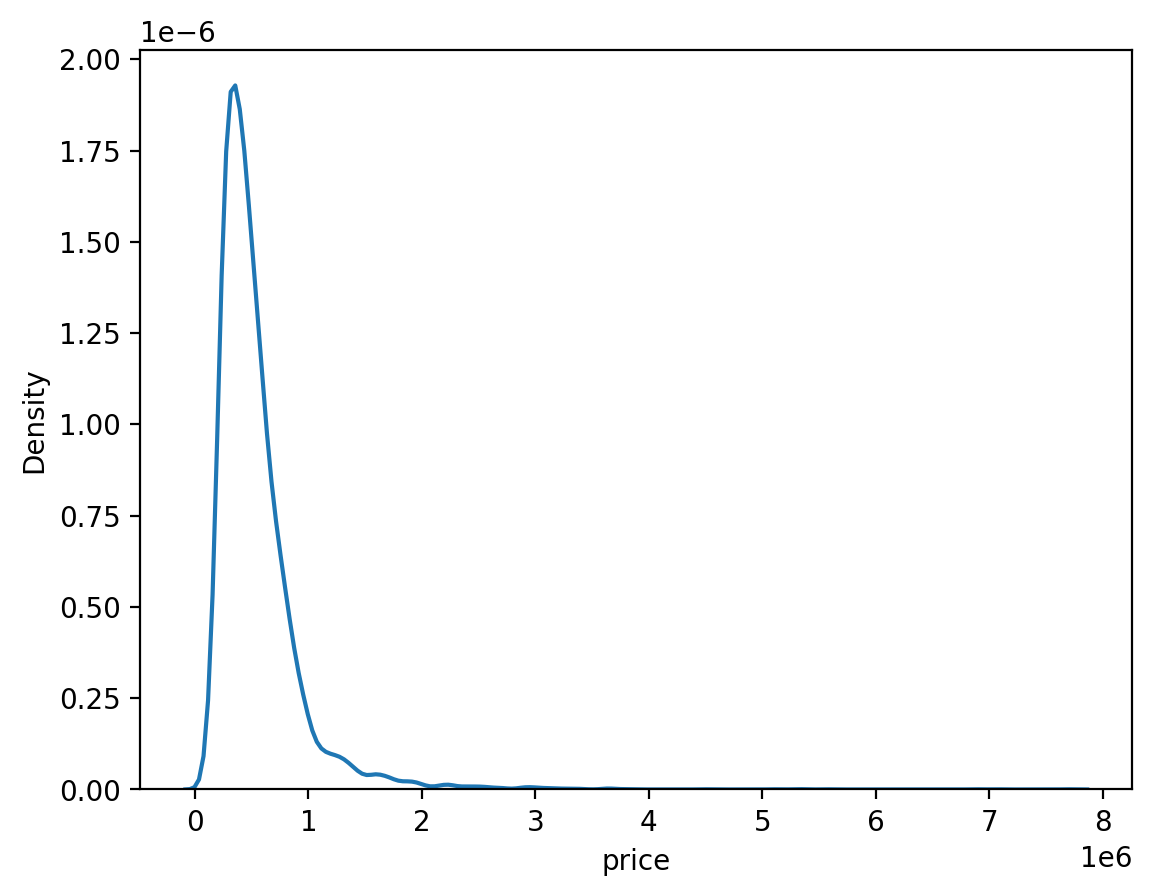

In [9]:
# y가 치우쳐져있다.
sns.kdeplot(y)
plt.show()

In [10]:
# 그러니까 로그취해준다.
y = np.log1p(y)

In [11]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

def get_scores(models, train, y):
    # 답안 작성
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df


def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [17]:
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
# df
get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,128360.196497
RandomForestRegressor,125367.297375
XGBRegressor,112334.521178
LGBMRegressor,111920.367359


In [21]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [i for i in range(50,800, 50)],
    'max_depth': [10],
}
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=4, verbose=1, n_jobs=-1)

grid_model.fit(x, y)

Fitting 4 folds for each of 15 candidates, totalling 60 fits


GridSearchCV(cv=4,
             estimator=LGBMRegressor(max_depth=10, n_estimators=1000,
                                     random_state=2020),
             n_jobs=-1,
             param_grid={'max_depth': [10],
                         'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400,
                                          450, 500, 550, 600, 650, 700, 750]},
             scoring='neg_mean_squared_error', verbose=1)

In [22]:
params = grid_model.cv_results_['params']
score = grid_model.cv_results_['mean_test_score']
results = pd.DataFrame(params)
results['score'] = score

results['RMSE'] = np.sqrt(-1 * results['score'])
results = results.rename(columns={'RMSE': 'RMSLE'})
results = results.sort_values('RMSLE')
results

,max_depth,n_estimators,score,RMSLE
4,10,250,-0.027194,0.164906
5,10,300,-0.027209,0.164952
3,10,200,-0.027223,0.164995
6,10,350,-0.027241,0.165049
7,10,400,-0.027260,0.165105
8,10,450,-0.027312,0.165263
9,10,500,-0.027355,0.165393
2,10,150,-0.027405,0.165545
10,10,550,-0.027418,0.165582
11,10,600,-0.027474,0.165753


In [14]:
del x['date']
del test['id']
del test['date']

In [24]:
model = XGBRegressor(max_depth=10, n_estimators=50, random_state=2020)
model.fit(x, y)

prediction = model.predict(test)
prediction = np.expm1(prediction)
submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission['price'] = prediction
submission_csv_path = '{}/submission.csv'.format(data_dir)
submission.to_csv(submission_csv_path, index=False)

### 회고
---

처음에는 최적의 모델을 찾으려 PyCaret library를 이용하려했지만 scikit-learn에 문제가있어 scikit-learn을 재설치하고 맞는 버전으로 설치하려시도했고, 가상환경을 따로 만들어 PyCaret을 설치하여 해결하였다. LMS에서 제공하는 cloud는 AutoML인 lazy predict를 실행시키면 커널이 죽는다. 그래서 로컬의 저사양 노트북을 이용해 autoML을 시행하였다. TPOT은 수 시간정도 모델을 찾는데 오려걸렸지만 Pycaret은 3분 정도가 소요되었다. TPOT과 PyCaret은 최적의 모델 뿐만 아니라 모델의 하이퍼파라미터도 탐색하여 더 정교한 결과를 나타낸다. TPOT과 PyCaret을 사용하여 결과는 루브릭 평가기준인 110000점 이하를 달성하지 못했다.


Pycaret. PyCaret은 튜닝 기능도 제공하는 AutoML library이다. 그 과정은 Shortlisting -> tuning -> finalization 순서이다. shortlisting으로 여러 모델들을 비교하고, 튜닝하고 finalization으로 완전히 데이터셋에 fitting시킨다. private score 119436.51936 점을 얻었다. 110000점 이하가 나와야 평가를 받을 수 있다.


PyCaret과 TPOT을 이용해 모델을 구했지만, 그 결과는 실망스러웠다.

캐글과 비슷한 국내의 '데이콘'에서는 많은 참가자가 대회에 참가하여 서로의 모델을 비교한다. 나도 한 번은 대회에 참여했지만 순위권 안에 들기 절대 쉽지않았다. 

submission하는 과정이 혼란스러웠는데, 이번 LMS를 진행하면서 더 제대로 알게되었다. 

gridSearch의 범위를 넓혀 시간이 오래걸렸다.

추가적으로 FLAML을 이용했다. 점수는 괜찮았지만, 110000점을 달성하지는 못했다.

AutoML alex를 이용했다. 점수는 제일 괜찮았고, 113000점 정도를 달성했다.

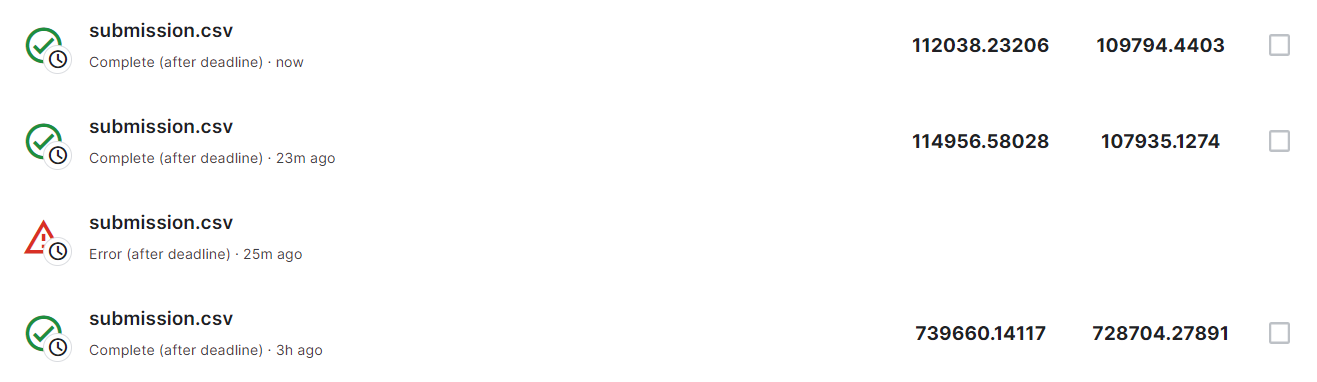
